In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np

#точное решение
def u(t:float, x:float) -> float:
    return math.sin(2*math.pi*x)*math.cos(math.pi*t)+2.5*math.pi*x

#коэффцициент в уравнении
def c(t:float, x:float) -> float: # c>=0 for 0<x<0.5, c<0 for 0.5<=x<=1.0
    return math.sin(2*math.pi*x)*math.sin(math.pi*t)/(2*math.cos(2*math.pi*x)*math.cos(math.pi*t)+2.5)

np.set_printoptions(precision=2)

In [3]:
n_count = 8
i_count = 8
h_x = 1/(n_count-1)
h_t = 1/(i_count-1)
x = [h_x * n for n in range(n_count)]
t = [h_t * i for i in range(i_count)]

In [15]:
# вбиваем краевые условия в нашу сетку
U = np.zeros((i_count, n_count))
for i in range(i_count):
    U[i, 0] = u(t[i], 0)
for n in range (n_count):
    U[0, n] = u(0, x[n])

In [16]:
print(U)

[[0.   1.9  3.22 3.8  4.05 4.64 5.95 7.85]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]]


In [20]:
#решим ВСЕ как первую явную схема
for i in range(1, i_count):
    for n in range(1, n_count):
        cur_c=c(t[i], x[n])
        U[i,n]=(cur_c*h_t*U[i, n-1]+h_x*U[i-1, n])/(h_x+cur_c*h_t)
#результат: слева все окей - ошибка как будто допустимая, 
#а справа начинаются ошибки, т.к. шаблон не похдодит для отрицательных c(t,x)

0.286
0.000 0.000


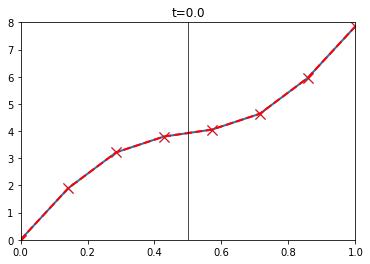

0.151 0.151


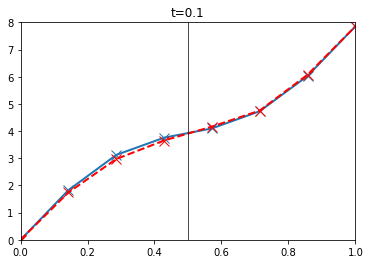

0.265 0.265


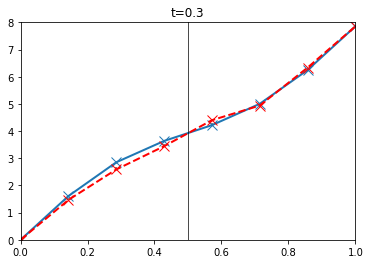

0.281 0.303


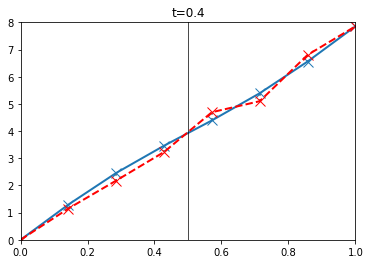

0.218 0.746


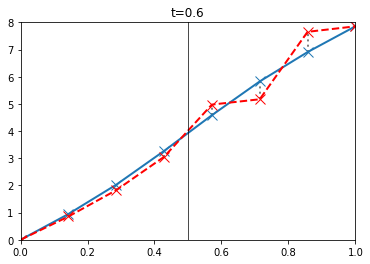

0.171 1.800


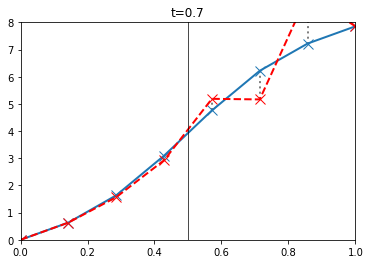

0.115 2.851


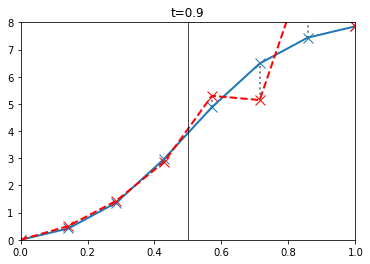

0.167 2.774


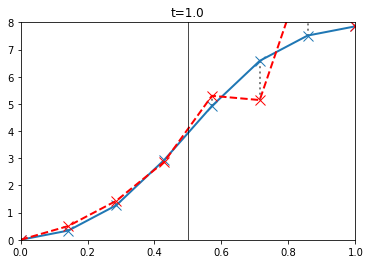

In [19]:
print("%.3f"%(h_t+h_x))
for i in range(i_count):
    u_x = [u(t[i], h_x * n) for n in range(n_count)]
    print("%.3f"%max([abs(U[i, n] - u_x[n]) for n in range(n_count//2)]),\
          "%.3f"%max([abs(U[i, n] - u_x[n]) for n in range(n_count)]))
    
    fig = plt.figure()
    plt.xlim([0,1])
    plt.ylim([0,8])
    [plt.plot([x[n],x[n]],[min(U[i, n], u(t[i], x[n])), max((U[i, n], u(t[i], x[n])))],':', color='grey', linewidth=2) for n in range(1, n_count)]
    plt.plot(x, u_x, marker='x', markersize=10, linewidth=2)
    plt.plot(x, U[i, :], '--', marker='x', color='red', markersize=10, linewidth=2)
    plt.plot([0.5,0.5], [0.0, 10], color='black', linewidth=0.7)
    plt.title('t=%.1f' % t[i])
    plt.show()

In [21]:
# ниже приведены попытки произвести вычисления так, чтобы не было проблем с нулевой c(t,x) в знаменателе
# т.к. эта проблема очевидно возникает, если выписать второй шаблон в явном виде

n_last_1 = int(max([n for n in range(n_count) if x[n]<=0.5]))

#решим левую половину как явную схема
for i in range(1, i_count):
    for n in range(1, n_last_1+1):
        cur_c=c(t[i], x[n])
        U[i,n]=(cur_c*h_t*U[i, n-1]+h_x*U[i-1, n])/(h_x+cur_c*h_t)
            

In [12]:
#решим правую половину как неявную схему
#может быть, исчезнет проблема с тем, в явной реализации c(t,x), которая зануляется, оказывается в знаменателе
#UPD: не помогло, при решении СЛАУ с(t,x) снова где-то оказывается в знаменателе
n_first_2 = n_last_1+1
dim = n_count-n_first_2

for i in range(1, i_count):
    matrix = np.zeros([dim, dim])
    vector = np.ndarray(dim)
    
    matrix[0,0]=c(t[i],x[n_first_2])*h_t/h_x
    for index in range(1, dim):
        r = c(t[i],x[n_last_1+index])*h_t/h_x
        matrix[index,index] = r
        matrix[index,index-1] = 1-r
        
    for index in range(dim):
        vector[index] = U[i-1, n_last_1+index]
    vector[0] -= U[i, n_last_1]*(1-c(t[i],x[n_last_1])*h_t/h_x)
    
    new_layer = np.linalg.solve(matrix,vector)
    for n in range(dim):
        U[i,n_first_2+n] = new_layer[n]